In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../utils')

import os
import sys

# Dynamically add 'src' to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)
#sys.path.append(os.path.join(project_root, 'src'))

#from utils.data import select_tomo_ids
#from utils.model_plot import plot_history_regression
#from ml_logic.preprocess import batches_images_ram,selection_images_labels,read_img_jpg
#from utils.image_padding import padd_picture


### 1. Pad and Save 2D Slices
def pad_image_to_square(image_path, save_path, target_size=960):
    img = Image.open(image_path).convert('RGB')
    padded_img = Image.new('RGB', (target_size, target_size), (255, 255, 255))
    padded_img.paste(img, (0, 0))
    padded_img.save(save_path)


def pad_all_tomos(raw_root, processed_root, tomo_ids, target_size=960):
    for tid in tomo_ids:
        in_dir = os.path.join(raw_root, tid)
        out_dir = os.path.join(processed_root, tid)
        os.makedirs(out_dir, exist_ok=True)
        for fname in os.listdir(in_dir):
            if fname.endswith('.jpg') or fname.endswith('.png'):
                pad_image_to_square(os.path.join(in_dir, fname), os.path.join(out_dir, fname), target_size)


### 2. Load Slices for a Single Tomogram
def load_stack(tomo_folder, n_slices=30, img_size=(240, 240)):
    slice_files = sorted([f for f in os.listdir(tomo_folder) if f.endswith('.jpg') or f.endswith('.png')])[:n_slices]
    stack = []
    for fname in slice_files:
        img = Image.open(os.path.join(tomo_folder, fname)).resize(img_size).convert('RGB')
        stack.append(np.array(img, dtype=np.float32) / 255.0)

    if len(stack) < n_slices:
        pad_img = np.ones((img_size[0], img_size[1], 3), dtype=np.float32)
        stack += [pad_img] * (n_slices - len(stack))

    return np.stack(stack, axis=0)  # Shape: (n_slices, H, W, 3)


### 3. Load All Tomograms
def load_dataset(tomo_paths, labels, n_slices=30, img_size=(240, 240)):
    X, y = [], []
    for path, label in zip(tomo_paths, labels):
        volume = load_stack(path, n_slices, img_size)
        X.append(volume)
        y.append(label)
    return np.array(X), np.array(y)


### 4. Create Train/Val/Test Sets
#def create_tf_datasets(X, y, batch_size=2, val_fraction=0.1, test_fraction=0.1):
#    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_fraction, random_state=42)
#    val_size = val_fraction / (1 - test_fraction)
#    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size,  random_state=42)

#    def to_dataset(X, y):
#        return tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#
#    return to_dataset(X_train, y_train), to_dataset(X_val, y_val), to_dataset(X_test, y_test)

from math import ceil

def create_tf_datasets(X, y, batch_size=2, val_fraction=0.2, test_fraction=0.2):
    total = len(X)
    n_test = max(1, int(total * test_fraction))
    n_val = max(1, int(total * val_fraction))
    n_train = total - n_val - n_test

    # Manual split for small dataset
    X, y = np.array(X), np.array(y)
    indices = np.arange(total)
    np.random.seed(42)
    np.random.shuffle(indices)

    X_train, y_train = X[indices[:n_train]], y[indices[:n_train]]
    X_val, y_val = X[indices[n_train:n_train + n_val]], y[indices[n_train:n_train + n_val]]
    X_test, y_test = X[indices[n_train + n_val:]], y[indices[n_train + n_val:]]

    def to_dataset(X, y):
        return tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return to_dataset(X_train, y_train), to_dataset(X_val, y_val), to_dataset(X_test, y_test)


/Users/benedettaveronesi/code/mc-will/BYU_Locating-Bacterial_Flagellar_Motors_2025


In [15]:
import pandas as pd

path_train_csv= '../data/csv_raw/train_labels.csv'
path_image= '../data/pictures_process/train_process'
df = pd.read_csv(path_train_csv).copy()
df.head(10)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0
1,1,30,tomo_098751,-1.0,-1.0,-1.0,500,924,956,16.1,0
2,2,54,tomo_136c8d,-1.0,-1.0,-1.0,500,924,956,19.7,0
3,3,59,tomo_146de2,-1.0,-1.0,-1.0,500,924,956,16.1,0
4,4,84,tomo_1dc5f9,-1.0,-1.0,-1.0,500,924,956,19.7,0
5,5,121,tomo_28f9c1,-1.0,-1.0,-1.0,500,924,956,16.1,0
6,6,173,tomo_39b15b,-1.0,-1.0,-1.0,500,924,956,16.1,0
7,7,181,tomo_3b8291,-1.0,-1.0,-1.0,500,924,956,19.7,0
8,8,193,tomo_40b215,-1.0,-1.0,-1.0,500,924,956,16.1,0
9,9,219,tomo_4baff0,-1.0,-1.0,-1.0,500,924,956,16.1,0


In [26]:
df_select = df[df['tomo_id'].isin(subdirs)]
df_select

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors


In [10]:

# Define your paths and labels
raw_root = "../data/pictures_raw/train"
processed_root = "../data/pictures_process/train_process"
tomo_ids = select_tomo_ids(df, number_of_slices=[300], number_of_motors=[0,1])
labels = [0, 1]  # Example corresponding labels


# Step 1: Pad slices
#pad_all_tomos(raw_root, processed_root, tomo_ids)

# Step 2: Build full paths
tomo_paths = [os.path.join(processed_root, tid) for tid in tomo_ids]
print(tomo_paths)


['../data/pictures_process/train_process/tomo_2dd6bd', '../data/pictures_process/train_process/tomo_3264bc', '../data/pictures_process/train_process/tomo_54e1a7', '../data/pictures_process/train_process/tomo_974fd4', '../data/pictures_process/train_process/tomo_b8595d', '../data/pictures_process/train_process/tomo_c3619a', '../data/pictures_process/train_process/tomo_d6e3c7', '../data/pictures_process/train_process/tomo_db2a10', '../data/pictures_process/train_process/tomo_e96200', '../data/pictures_process/train_process/tomo_fd41c4', '../data/pictures_process/train_process/tomo_285454', '../data/pictures_process/train_process/tomo_0308c5', '../data/pictures_process/train_process/tomo_0333fa', '../data/pictures_process/train_process/tomo_066095', '../data/pictures_process/train_process/tomo_06e11e', '../data/pictures_process/train_process/tomo_072a16', '../data/pictures_process/train_process/tomo_0c2749', '../data/pictures_process/train_process/tomo_0d4c9e', '../data/pictures_process/t

In [13]:
# Step 3: Load volumes
X, y = load_dataset(tomo_paths, labels)


In [ ]:
# Step 4: Create train/val/test datasets
train_ds, val_ds, test_ds = create_tf_datasets(X, y)


2025-06-06 17:37:28.929596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Step 5: Print a batch shape
for volume, label in train_ds.take(1):
    print("Volume shape:", volume.shape)
    print("Label shape:", label.shape)

In [117]:
%load_ext autoreload
%autoreload 2

# Trying 3D model 

In [59]:

path_train_csv= '../data/csv_raw/train_labels.csv'
path_tomos= '../data/pictures_process/train_process/tomo_adaptequal_1'
df = pd.read_csv(path_train_csv).copy()
df.head(5)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0
1,1,30,tomo_098751,-1.0,-1.0,-1.0,500,924,956,16.1,0
2,2,54,tomo_136c8d,-1.0,-1.0,-1.0,500,924,956,19.7,0
3,3,59,tomo_146de2,-1.0,-1.0,-1.0,500,924,956,16.1,0
4,4,84,tomo_1dc5f9,-1.0,-1.0,-1.0,500,924,956,19.7,0


In [60]:
print(df['Array_shape_axis_0'].unique())
print(df['Number_of_motors'].unique())
print(df.dtypes)

[500 800 600 300 400 494]
[ 0  1  2  3  4  6 10]
Unnamed: 0              int64
row_id                  int64
tomo_id                object
Motor_axis_0          float64
Motor_axis_1          float64
Motor_axis_2          float64
Array_shape_axis_0      int64
Array_shape_axis_1      int64
Array_shape_axis_2      int64
Voxel_spacing         float64
Number_of_motors        int64
dtype: object


In [69]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from pathlib import Path
import os
import glob
import sys


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score
from tensorflow.keras import Sequential, Input, layers
from tensorflow_addons.metrics import FBetaScore
from tensorflow.keras.metrics import Recall, Precision

sys.path.append('../src')
from src.utils.data import get_csv_from_bq,select_tomo_ids
from src.utils.model_plot import plot_history_regression
from src.ml_logic.preprocess import batches_images_ram,selection_images_labels,read_img_jpg

In [70]:

def selection_image_stacks_and_labels(df, base_dir, num_slices=[300], num_motors=[0,1], xy=False, z=True):
    """
    Returns list of lists of image paths (each list has 30 slices) and their associated labels.

    Parameters:
    -----------
    df : pd.DataFrame
        Metadata dataframe containing tomo_ids and motor info.
    base_dir : str or Path
        Base directory containing tomo_id subdirectories (each with 30 slices).
    num_slices : list
        Slice count filters passed to select_tomo_ids().
    num_motors : list
        Motor count filters passed to select_tomo_ids().
    xy : bool
        Whether to return (x, y) motor coordinates.
    z : bool
        Whether to return z motor coordinates.

    Returns:
    --------
    stack_paths : list of list of str
        Each element is a list of 30 image paths corresponding to a tomo stack.
    labels : np.ndarray
        Corresponding labels (z or xy).
    """

    base_dir = Path(base_dir)

    # Step 1: Filter tomos based on conditions
    df_tomos = df[(df['Array_shape_axis_0'].isin(num_slices)) & (df['Number_of_motors'].isin(num_motors))].copy()
    tomo_ids = df_tomos.tomo_id
    df_select = df[df['tomo_id'].isin(tomo_ids)].copy()

    # Step 2: Build labels
    if xy:
        df_select['motor_coord'] = df_select.apply(lambda row: (row['Motor_axis_2'], row['Motor_axis_1']), axis=1)
    if z:
        df_select['motor_z'] = df_select['Motor_axis_0']

    stack_paths = []
    labels = []

    for _, row in df_select.iterrows():
        tomo_id = row['tomo_id']
        tomo_stack_dir = base_dir / tomo_id

        if tomo_stack_dir.is_dir():
            # Collect slice files and sort to keep consistent order
            slice_files = sorted(tomo_stack_dir.glob('*.jpg'))
            if len(slice_files) == 30:
                # Append list of full paths (as strings)
                stack_paths.append([str(p) for p in slice_files])
                if xy:
                    labels.append(row['motor_coord'])
                if z:
                    labels.append(row['motor_z'])
            else:
                print(f"⚠️ Tomo {tomo_id} has {len(slice_files)} slices (expected 30). Skipping.")
        else:
            print(f"⚠️ Directory for tomo_id {tomo_id} not found.")

    labels = np.array(labels, dtype=np.float32)
    print(f"✅ Matched {len(stack_paths)} tomo stacks with 30 slices")

    return stack_paths, labels

In [74]:
stack_paths, labels = selection_image_stacks_and_labels(df, path_tomos, num_slices=[300], num_motors=[1], xy=False, z=True)
stack_paths, labels

✅ Matched 305 tomo stacks with 30 slices


([['../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0001.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0002.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0003.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0004.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0005.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0006.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0007.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0008.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0009.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0010.jpg',
   '../data/pictures_process/train_process/tomo_adaptequal_1/tomo_05df8a/mean_0011.jpg',
   '../data/pictures_

In [92]:
def read_stack_jpg(image_paths, label, target_size=(240,240)):
    """
    Reads a list of JPEG image paths representing one 3D stack,
    decodes each slice to grayscale, normalizes, and stacks into a 4D tensor.

    Parameters:
    -----------
    image_paths : tf.Tensor (tf.string)
        1D tensor of 30 file paths (strings) for one tomo stack.

    label : tf.Tensor or any
        Label associated with the stack.

    Returns:
    --------
    img_stack : tf.Tensor
        4D tensor of shape (30, height, width, 1) with normalized pixel values.
    label : same as input
        Unchanged label.
    """
    def _read_one_slice(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, target_size)  # resize to fixed size
        img = tf.image.convert_image_dtype(img, tf.float32)  # normalize to [0,1]
        return img

    # Map _read_one_slice over the list of image paths
    img_stack = tf.map_fn(_read_one_slice, image_paths, fn_output_signature=tf.float32)
    return img_stack, label


In [93]:
def batches_images_ram(
    read_stack_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=False,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42,
):
    """
    Load images and labels as tf.data.Dataset, optionally shuffle and batch,
    and optionally split into train/val/test datasets.

    Parameters:
    -----------
    read_img_jpg : function
        Function to load and preprocess image from path.

    filtered_image_paths : list or np.array
        List of image paths.

    labels : np.array or list
        Corresponding labels.

    shuffle : bool, default=True
        Whether to shuffle the dataset.

    batch_size : int, default=32
        Batch size.

    split : bool, default=False
        Whether to split dataset into train/val/test.

    val_fraction : float, default=0.2
        Fraction of data for validation.

    test_fraction : float, default=0.2
        Fraction of data for testing.

    seed : int, default=42
        Random seed for shuffling.

    Returns:
    --------
    If split=False:
        dataset : tf.data.Dataset
            Dataset with (image, label) pairs, batched and optionally shuffled.

    If split=True:
        train_ds, val_ds, test_ds : tf.data.Dataset
            The three splits, all batched and shuffled as specified.
    """

    dataset_size = len(filtered_image_paths)
    print(dataset_size)
    # Combine and optionally shuffle the data as a list of tuples
    data = list(zip(filtered_image_paths, labels))
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(data)

    # Unzip the shuffled data back
    filtered_image_paths, labels = zip(*data)

    # Convert back to lists or arrays
    filtered_image_paths = list(filtered_image_paths)
    labels = list(labels)

    if split:
        # Compute sizes
        val_size = int(val_fraction * dataset_size)
        test_size = int(test_fraction * dataset_size)
        train_size = dataset_size - val_size - test_size

        # Split into slices
        test_paths = filtered_image_paths[:test_size]
        test_labels = labels[:test_size]

        val_paths = filtered_image_paths[test_size:test_size + val_size]
        val_labels = labels[test_size:test_size + val_size]

        train_paths = filtered_image_paths[test_size + val_size:]
        train_labels = labels[test_size + val_size:]

        # Create tf.data.Dataset for each
        train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(read_stack_jpg).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(read_stack_jpg).batch(batch_size)
        test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(read_stack_jpg).batch(batch_size)

        return train_ds, val_ds, test_ds, test_paths, test_labels

    else:
        # Single dataset
        dataset = tf.data.Dataset.from_tensor_slices((filtered_image_paths, labels))
        dataset = dataset.map(read_stack_jpg).batch(batch_size)
        return dataset, filtered_image_paths, labels


In [94]:
#stack_paths, labels = selection_image_stacks_and_labels(df, base_dir, num_slices=[300], num_motors=[0,1], xy=False, z=True)

train_ds, val_ds, test_ds, test_paths, test_labels = batches_images_ram(
    read_stack_jpg,
    stack_paths,
    labels,
    shuffle=True,
    batch_size=4,
    split=True,
    val_fraction=0.2,
    test_fraction=0.2
)

305


In [95]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 30, 240, 240, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [96]:
for images, labels in train_ds.take(1):  # take one batch
    print("Images batch shape:", images.shape)  # should be (batch_size, 30, H, W, 1)
    print("Labels batch shape:", labels.shape)
    # Inspect first stack in batch
    first_stack = images[0]  # shape (30, H, W, 1)
    print("First stack shape:", first_stack.shape)
    print("Label for first stack:", labels[0].numpy())

    # Optionally look at min/max pixel values to check normalization
    print("Pixel value range:", tf.reduce_min(first_stack).numpy(), "-", tf.reduce_max(first_stack).numpy())

Images batch shape: (4, 30, 240, 240, 1)
Labels batch shape: (4,)
First stack shape: (30, 240, 240, 1)
Label for first stack: 208.0
Pixel value range: 0.0 - 255.0


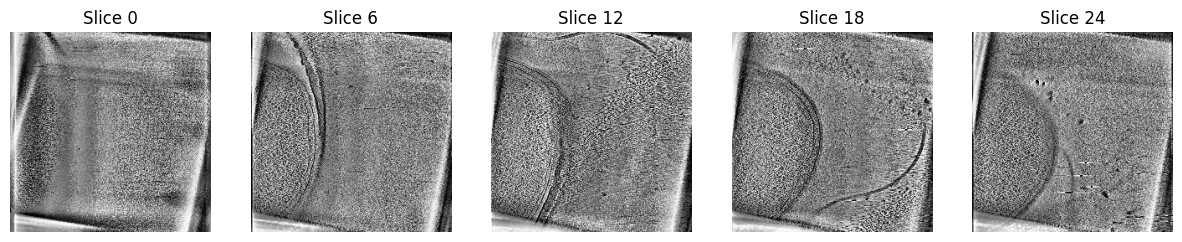

In [97]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    first_stack = images[0]  # (30, H, W, 1)
    first_stack = tf.squeeze(first_stack)  # (30, H, W)

    # Plot a few slices
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(first_stack[i*6].numpy(), cmap='gray')  # show slices 0,6,12,18,24
        ax.axis('off')
        ax.set_title(f"Slice {i*6}")
    plt.show()

In [104]:
for images, labels in train_ds.take(1):
    sample_shape = images.shape[1:]  # skip batch dimension
    print('shape with batch', images.shape)
    print(sample_shape)  # e.g. (30, 240, 240, 1)

shape with batch (4, 30, 240, 240, 1)
(30, 240, 240, 1)


In [105]:
def initiate_model3D(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # e.g. (30, 240, 240, 1)
    model.add(layers.Conv3D(32, (3,3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool3D(pool_size=(3,3,3)))
    model.add(layers.Conv3D(64, (4,4,4), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool3D(pool_size=(3,3,3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='linear'))
    return model

In [106]:
model = initiate_model3D(sample_shape)
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 30, 240, 240, 32)  896       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 240, 240, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 32)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 10, 80, 80, 64)    131136    
                                                                 
 batch_normalization_10 (Bat  (None, 10, 80, 80, 64)   256       
 chNormalization)                                                
                                                      

In [107]:
import tensorflow as tf
def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_pred - y_true, axis=1))
def compile_model3D_regress(model):
    ### Model compilation
    #model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['FBetaScore',Recall(),'precision','accuracy'], run_eagerly=True)

    model.compile(loss=euclidean_loss,
                  optimizer = 'adam',
                  metrics=[euclidean_loss],)

    return model


In [109]:
from src.ml_logic.interface import train
model = initiate_model3D(sample_shape)
model = compile_model3D_regress(model)

train(model,
        train_ds,
        val_ds,
        model_type='pos3D for z',
        preprocess_type='mean_contraste',
        model_name='pos3D for z mean contraste patience 5 ',
        batch_size = 16,
        patience = 5
    )


🏋️ Starting model training ...

Training model...
Epoch 1/100
46/46 [==============================] - 1006s 22s/step - loss: 106.4719 - euclidean_loss: 106.0451 - val_loss: 1151.3572 - val_euclidean_loss: 1151.2351
Epoch 2/100
46/46 [==============================] - 742s 16s/step - loss: 76.6993 - euclidean_loss: 76.6522 - val_loss: 265.5233 - val_euclidean_loss: 267.1916
Epoch 3/100
46/46 [==============================] - 656s 14s/step - loss: 71.3952 - euclidean_loss: 71.0518 - val_loss: 76.6752 - val_euclidean_loss: 78.3607
Epoch 4/100
46/46 [==============================] - 655s 14s/step - loss: 66.7737 - euclidean_loss: 66.5558 - val_loss: 34.2382 - val_euclidean_loss: 33.6795
Epoch 5/100
46/46 [==============================] - 658s 14s/step - loss: 69.8208 - euclidean_loss: 69.7773 - val_loss: 41.1605 - val_euclidean_loss: 39.4296
Epoch 6/100
46/46 [==============================] - 657s 14s/step - loss: 64.5693 - euclidean_loss: 64.5874 - val_loss: 57.4744 - val_euclidean_

INFO:tensorflow:Assets written to: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmp5ee3xuz9/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmp5ee3xuz9/model/data/model/assets
2025/06/10 15:30:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmp5ee3xuz9/model, flavor: tensorflow), fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback.
2025/06/10 15:30:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/benedettaveronesi/.pyenv/versions/3.10.6/envs/flagelleux/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2025/06/10 15:30:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


✅ Model trained with min val Eucledian Loss: 33.31
✅ Results saved on mlflow


INFO:tensorflow:Assets written to: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmpi7z_k_kr/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmpi7z_k_kr/model/data/model/assets
2025/06/10 15:30:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmpi7z_k_kr/model, flavor: tensorflow), fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback.
Successfully registered model 'pos3D for z mean contraste patience 5 '.
2025/06/10 15:30:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: pos3D for z mean contraste patience 5 , version 1
Created version '1' of model 'pos3D for z mean contraste patience 5 '.


✅ Model saved to mlflow
✅ Model pos3D for z mean contraste patience 5  (version 1) transitioned from None to staging
✅ train() done 

✅ mlflow_run auto-log done


In [121]:

import importlib
import src.ml_logic.interface_BV as interface

# When you've made changes to the module:
importlib.reload(interface)


interface.evaluate(test_ds, model_name='pos3D for z mean contraste patience 5 ',stage='Staging')


⭐️ Use case: evaluate

Load model [pos3D for z mean contraste patience 5 ] from MLflow...


ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.